# **Cats vs Dog Image Classification CNNs**

---

## **1. Business Objective**

Image classification is the process of taking an input (like a picture) and outputting a class or a probability that the input is a particular class.

The convolutional neural network (CNN) is a class of deep learning neural networks. CNNs represent a huge breakthrough in image recognition.

The main aim of the project is to distinguish which image contains a dog in it and which one has a cat in it.




## **2. Data Collection**

The data was collected from Kaggle.

Link: https://www.kaggle.com/c/dogs-vs-cats/data

Kaggle had hosted this very popular contest in late 2013 to classify cat & dog images into the appropriate class.

The train.zip archive consists of 25,000 images of different sizes (12,500 of each class!). This is a huge dataset to train our model on. 

However, we have trained the model on a much smaller dataset, consisting of randomly selected images from train set to create — 5,000 training images, 1,000 eval images and 500 test images each of cats and dogs.

In [7]:
# Connecting to Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Importing the necessary libraries

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [9]:
# Setting up some parameters for the workbook

pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = None

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (25,5)
plt.style.use('seaborn')

In [10]:
# Importing the ML/DL libraries

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import VGG16

In [11]:
# Importing few helper libraries

import sys 
import os
import random
import shutil
import zipfile
from datetime import datetime

seed = 123
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## **3. Data Preparation/Preprocessing**

We will start with loading and familiarizing with the dataset so that we can prepare the data for Machine Learning (ML) modelling.

In [24]:
# Loading the dataset

DRIVE_ZIP_DIR = "/content/drive/MyDrive/Colab Datasets/Cats vs Dog Classification"
source_file = os.path.join(DRIVE_ZIP_DIR, "Cats and Dogs Sampled Data.zip")
local_zip = "/tmp/Cats and Dogs Sampled Data.zip"

print("Copying from drive %s to %s..." % (source_file, local_zip), flush=True)
shutil.copyfile(source_file, local_zip)
assert os.path.exists(local_zip)

print('Extracting all images...', flush=True)
zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

print("Done..")

Copying from drive /content/drive/MyDrive/Colab Datasets/Cats vs Dog Classification/Cats and Dogs Sampled Data.zip to /tmp/Cats and Dogs Sampled Data.zip...
Extracting all images...
Done..


In [26]:
# All images have been un-zipped under this folder.
# There are three sub-folders for training, validation and testing image sets

images_root = "/tmp/Sampled Data"
assert os.path.exists(images_root), "%s folder does not exist!" % images_root

train_root = os.path.join(images_root, "train")
train_root_cat = os.path.join(train_root, "cat")
train_root_dog = os.path.join(train_root, "dog")

eval_root = os.path.join(images_root, "eval")
eval_root_cat = os.path.join(eval_root, "cat")
eval_root_dog = os.path.join(eval_root, "dog")

test_root = os.path.join(images_root, "test")
test_root_cat = os.path.join(test_root, "cat")
test_root_dog = os.path.join(test_root, "dog")

IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, BATCH_SIZE = 224, 224, 3, 32

## **4. Model Building**

We will be using VGG16 pre-trained model to use transfer learning to train our custom model for classifying cats and dogs images.

In [27]:
vgg_base = VGG16(weights='imagenet',    # use weights for ImageNet
                 include_top=False,     # don't use upper Dense layers
                 input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))

print(vgg_base.summary())

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [40]:
# Building a Fuction to define custom architecture on top of the VGG16 as base model

def BuildCustomizedModel():
    
    model = tf.keras.models.Sequential([
        vgg_base,
        # here is our custom prediction layer
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(1, activation='sigmoid')    
    ])
    
    # mark vgg_base as non-trainable, so training updates
    # weights and biases of just our newly added layers
    vgg_base.trainable = False    
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [41]:
# Creating the final model architecture

model_xfer = BuildCustomizedModel()
print(model_xfer.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [42]:
# Defining the ImageGenerators for train, val and test image sets

# Applying data augmentation to train data only
train_datagen = ImageDataGenerator(rescale=1.0/255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
eval_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [43]:
# Flow from train root folders

train_generator = train_datagen.flow_from_directory(
                                                    train_root,
                                                    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary'
                                                    )

eval_generator = eval_datagen.flow_from_directory(
                                                  eval_root,
                                                  target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='binary'
                                                  )

test_generator = test_datagen.flow_from_directory(
                                                  test_root,
                                                  target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='binary'
                                                  )

Found 10000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [44]:
# Train model on generator

train_steps = train_generator.n // BATCH_SIZE
val_steps = eval_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE

print("The Steps for the 3 datasets are : ({}, {}, {})".format(train_steps, val_steps, test_steps))

The Steps for the 3 datasets are : (312, 125, 31)


In [45]:
# Training our model

startTime = datetime.now()
print("Training started..")

history = model_xfer.fit(
                          train_generator,
                          steps_per_epoch=train_steps,
                          epochs=50,
                          validation_data=eval_generator,
                          validation_steps=val_steps,
                        )

print("The training is complete after taking time of ", (datetime.now() - startTime))

Training started..
Epoch 1/50
312/312 [==============================] - 149s 477ms/step - loss: 0.7677 - accuracy: 0.5050 - val_loss: 0.6720 - val_accuracy: 0.6045
Epoch 2/50
312/312 [==============================] - 147s 471ms/step - loss: 0.6933 - accuracy: 0.5508 - val_loss: 0.6502 - val_accuracy: 0.7023
Epoch 3/50
312/312 [==============================] - 146s 467ms/step - loss: 0.6746 - accuracy: 0.5791 - val_loss: 0.6302 - val_accuracy: 0.7442
Epoch 4/50
312/312 [==============================] - 147s 470ms/step - loss: 0.6538 - accuracy: 0.6211 - val_loss: 0.6112 - val_accuracy: 0.7720
Epoch 5/50
312/312 [==============================] - 144s 462ms/step - loss: 0.6389 - accuracy: 0.6457 - val_loss: 0.5933 - val_accuracy: 0.7883
Epoch 6/50
312/312 [==============================] - 144s 462ms/step - loss: 0.6194 - accuracy: 0.6791 - val_loss: 0.5762 - val_accuracy: 0.8040
Epoch 7/50
312/312 [==============================] - 144s 463ms/step - loss: 0.6062 - accuracy: 0.7010 -

In [48]:
# Saving the model to drive

model_xfer.save(DRIVE_ZIP_DIR + "/cats_vs_dogs_pretrained_vgg16.h5")

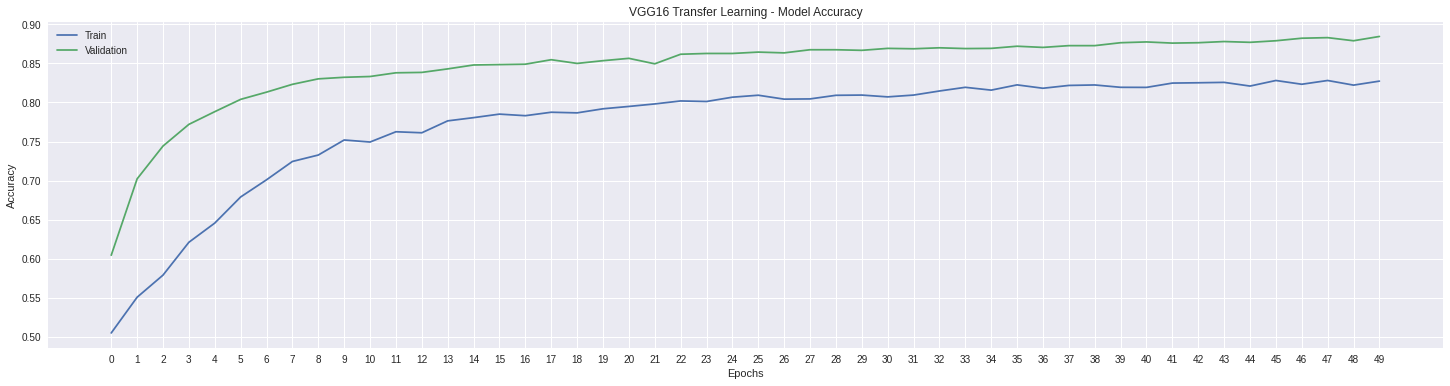

In [52]:
# Visualizing the Train and Validation accuracy

plt.style.use("seaborn")
plt.figure(figsize=(25, 6))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

plt.title("VGG16 Transfer Learning - Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="upper left")
_ = plt.xticks(range(0, 50))

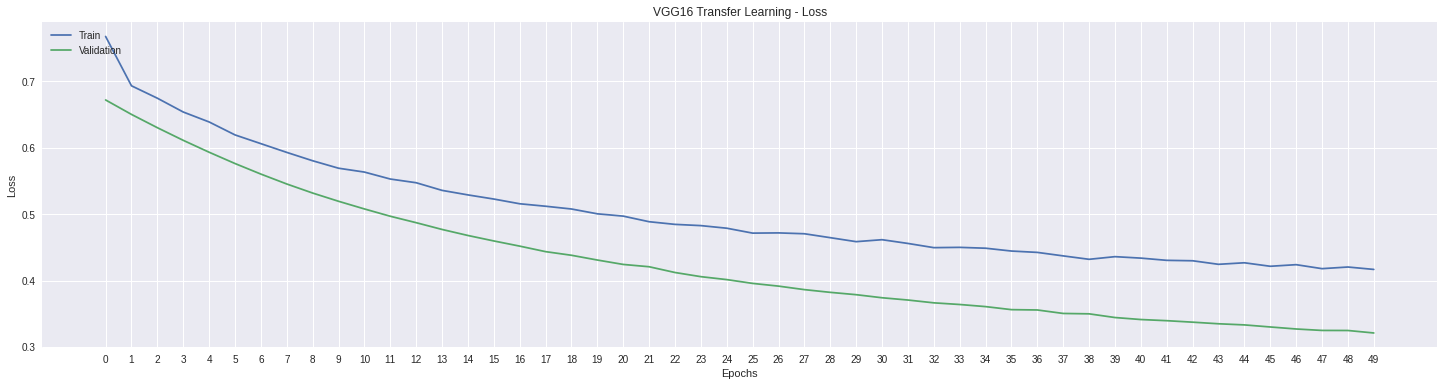

In [53]:
# Visualizing the Train and Validation loss

plt.style.use("seaborn")
plt.figure(figsize=(25, 6))

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

plt.title("VGG16 Transfer Learning - Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="upper left")
_ = plt.xticks(range(0, 50))

In [54]:
# evaluate performance on train & test data

loss, acc = model_xfer.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print("Training data  -> loss: %.3f, acc: %.3f" % (loss, acc))

loss, acc = model_xfer.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print("Cross-val data -> loss: %.3f, acc: %.3f" % (loss, acc))

loss, acc = model_xfer.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print("Testing data   -> loss: %.3f, acc: %.3f" % (loss, acc))

Instructions for updating:
Please use Model.evaluate, which supports generators.
312/312 [==============================] - 142s 454ms/step - loss: 0.3966 - accuracy: 0.8513
Training data  -> loss: 0.397, acc: 0.851
125/125 [==============================] - 18s 142ms/step - loss: 0.3210 - accuracy: 0.8845
Cross-val data -> loss: 0.321, acc: 0.885
31/31 [==============================] - 4s 139ms/step - loss: 0.3329 - accuracy: 0.8810
Testing data   -> loss: 0.333, acc: 0.881


Observations:

We were able to use VGG16 pre-trained model to customize it for our objective and achieved accuracy of 85% on Training set, 88% on Validation and Testing sets.

In [50]:
# Load the model

base_file_name = "cats_vs_dogs_pretrained_vgg16.h5"
model = load_model(DRIVE_ZIP_DIR + "/" + base_file_name)

In [71]:
# Fucntion to show the image

def show_image(entry):

    import numpy as np
    from keras.preprocessing import image
    import matplotlib.pyplot as plt
    
    img = image.load_img(entry, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    img_arr = image.img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    img_arr /= 255.

    plt.imshow(img_arr[0])
    plt.show()

    return img_arr

def PredictLabels(imagepath, model):

    print("Loading image")
    img = show_image(imagepath)

    print("Predicting output : ")
    prediction = model.predict(img)
    label = prediction[0]
    if label >= 0.5:
        text = "It looks like a bit of a Dog"
    else:
        text = "It looks like a bit of a Cat"

    # output text
    print(text + ".")

In [72]:
# Creating Testing image path list

cat_test_files = np.array(os.listdir(test_root_cat))
dog_test_files = np.array(os.listdir(test_root_dog))

for _ in range(5):
    np.random.shuffle(cat_test_files)
    np.random.shuffle(dog_test_files)

test_image_files = []
for image in cat_test_files:
    test_image_files.append(os.path.join(test_root_cat, image))
for image in dog_test_files:
    test_image_files.append(os.path.join(test_root_dog, image))
test_image_files = np.array(test_image_files)

for _ in range(5): 
    indexes = np.random.permutation(range(len(test_image_files)))
test_image_files = test_image_files[indexes]

Loading image


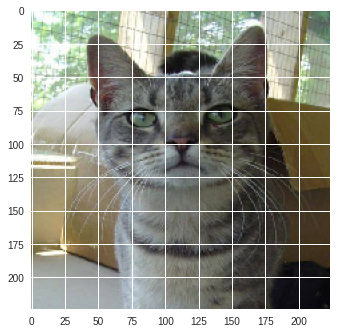

Predicting output : 
It looks like a bit of a Cat.


In [73]:
path = random.choice(test_image_files)

PredictLabels(path, model)

Loading image


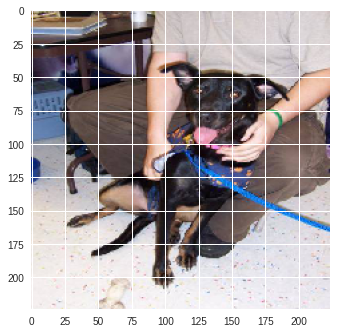

Predicting output : 
It looks like a bit of a Dog.


In [74]:
path = random.choice(test_image_files)

PredictLabels(path, model)

## **5. Conclusion**

We are able to achieve a training accuracy of 85% and a validation accuracy of 88% using VGG16 transfer learning. 

Our model learned to successfully identify both dogs and cats. Its predictions are very confident in the majority of the cases and they are lower only for anything that’s unusual like pose, fur color etc. It’s definitely expected behavior because our model has trained on less amount of such uncommon data.

We can further improve our accuracy by a significant amount using data augmentation, training epochs and using different architectures to extract even better features.